In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import sklearn as sk
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division
from collections import Counter

In [2]:
# Read the training data
raw = pd.read_table( '../input/train.csv', delimiter=',')

In [3]:
raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


In [4]:
# Check which columns have missing values
raw.apply(lambda x: sum(x.isnull())/len(x))

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

In [5]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


In [6]:
# Look at estimating the missing ages 
ageData = raw.groupby([x.split()[1] for x in raw.Name]).Age
# raw[raw.Age.isnull()]

In [7]:
def print_cats(df):
    for col in ['Pclass', 'Sex', 'Embarked']:
        print col
        print Counter(df[col]).most_common()

In [8]:
print_cats(raw)

Pclass
[(3, 491), (1, 216), (2, 184)]
Sex
[('male', 577), ('female', 314)]
Embarked
[('S', 644), ('C', 168), ('Q', 77), (nan, 2)]


In [9]:
def clean(raw):
    cleaned = raw.copy()
    cleaned.loc[cleaned['Age'].isnull(), ['Age']] = np.nanmedian(raw['Age'])
    cleaned.loc[cleaned['Embarked'].isnull(),['Embarked']] = Counter(raw['Embarked']).most_common(1)[0][0]
    # Take group median for missing Fares
    data = cleaned.groupby('Pclass')['Fare']
    cleaned['Fare'] = data.transform( lambda x: x.fillna(x.median()))    
    cleaned['IsChild'] = 1.0*(cleaned['Age'] < 20)
    cleaned['IsFemale'] = 1.0*(cleaned['Sex'] == 'male')
    cleaned['IsUpperClass'] = 1.0*(cleaned['Pclass']==1)
    cleaned['HighFareBucket'] = 1.0*(cleaned['Fare'] >= np.percentile(cleaned['Fare'], 50))
    return cleaned

In [10]:
cleaned = clean(raw)
cleaned.apply(lambda x: sum(x.isnull())/len(x))

PassengerId       0.000000
Survived          0.000000
Pclass            0.000000
Name              0.000000
Sex               0.000000
Age               0.000000
SibSp             0.000000
Parch             0.000000
Ticket            0.000000
Fare              0.000000
Cabin             0.771044
Embarked          0.000000
IsChild           0.000000
IsFemale          0.000000
IsUpperClass      0.000000
HighFareBucket    0.000000
dtype: float64

([array([  18.,   27.,  114.,  229.,   66.,   46.,   24.,   15.,    9.,    1.]),
  array([  36.,   19.,   63.,  117.,   52.,   24.,   21.,    9.,    0.,    1.])],
 array([  0.42 ,   8.378,  16.336,  24.294,  32.252,  40.21 ,  48.168,
         56.126,  64.084,  72.042,  80.   ]),
 <a list of 2 Lists of Patches objects>)

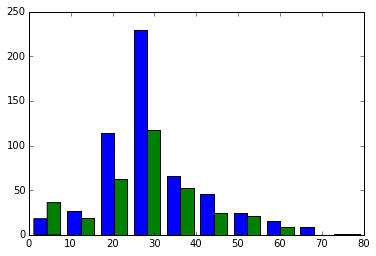

In [14]:
# Histogram of survival vs age
plt.hist([cleaned['Age'][cleaned['Survived']==0],cleaned['Age'][cleaned['Survived']==1]])

In [15]:
print_cats(cleaned)

Pclass
[(3, 491), (1, 216), (2, 184)]
Sex
[('male', 577), ('female', 314)]
Embarked
[('S', 646), ('C', 168), ('Q', 77)]


In [16]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [17]:
nTrain = 891
features = ['IsFemale', 'IsChild', 'Pclass', 'Fare']

In [18]:
cleaned.groupby(features)['Survived'].mean()

IsFemale  IsChild  Pclass  Fare   
0         0        1       25.9292    1
                           26.5500    1
                           27.7208    1
                           28.7125    0
                           31.0000    1
                           39.6000    1
                           49.5000    1
                           49.5042    1
                           51.4792    1
                           51.8625    1
                           52.0000    1
                           52.5542    1
                           53.1000    1
                           55.0000    1
                           55.9000    1
...
1         1        3       15.9000    1.0
                           18.0000    0.0
                           18.7875    0.0
                           20.2125    0.0
                           20.2500    0.0
                           20.5250    1.0
                           20.5750    1.0
                           21.0750    0.0
                         

In [19]:
# clf = MultinomialNB()
clf = RandomForestClassifier()
clf.fit(cleaned[features].values, cleaned['Survived'].values)

RandomForestClassifier(bootstrap=True, compute_importances=None,
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
            min_samples_split=2, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0)

In [20]:
confusion_matrix(cleaned.Survived.values,clf.predict(cleaned[features].values))

array([[517,  32],
       [ 48, 294]])

In [21]:
accuracy_score(cleaned.Survived.values,clf.predict(cleaned[features].values), normalize=True) 

0.91021324354657684

In [22]:
# Predict the test set
test = pd.read_table('../input/test.csv', delimiter=',')
cleaned_test = clean(test)
cleaned_test['Survived'] = clf.predict(cleaned_test[features].values )

In [23]:
cleaned_test[['PassengerId', 'Survived']].describe()

,PassengerId,Survived
count,418.000000,418.000000
mean,1100.500000,0.351675
std,120.810458,0.478065
min,892.000000,0.000000
25%,996.250000,0.000000
50%,1100.500000,0.000000
75%,1204.750000,1.000000
max,1309.000000,1.000000


In [24]:
cleaned_test.to_csv('random_forest_prediction_with_pclass.csv', columns=['PassengerId', 'Survived'], index=False)